In [ ]:
# Imports

import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path ="/content/drive/MyDrive/2025-2/Machine Learning/proyecto1/"
train_df = pd.read_csv(path + "datos_entrenamiento_riesgo.csv")
test_df = pd.read_csv(path +  "datos_prueba_riesgo.csv")


=== Análisis Bivariado - Entrenamiento ===


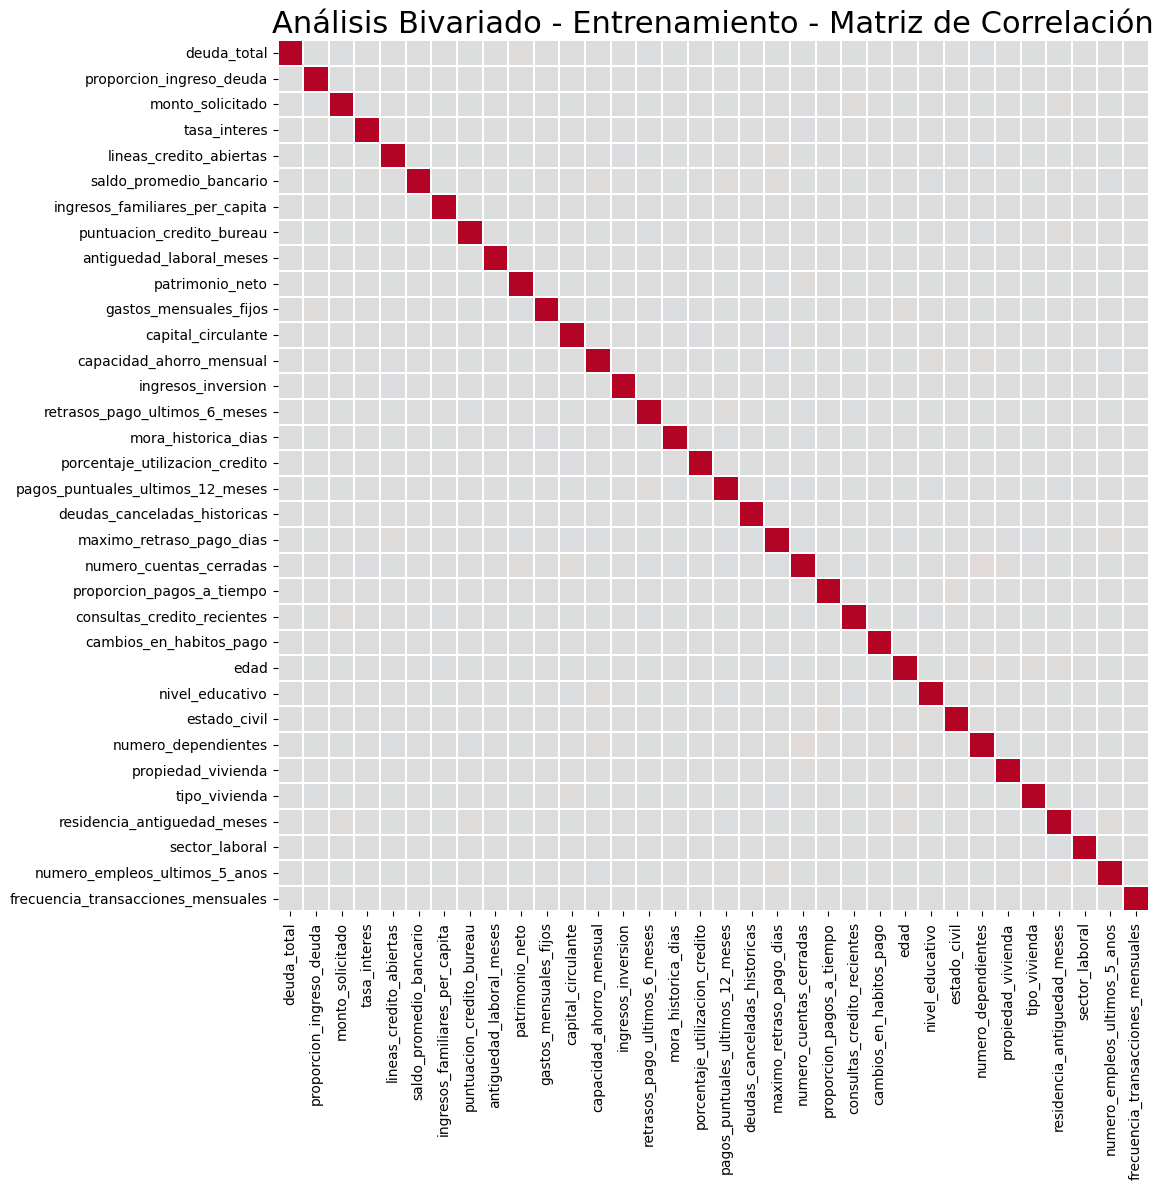

Correlaciones altas (>0.8): 0


/tmp/ipython-input-1071246926.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(mode_train, inplace=True)
/tmp/ipython-input-1071246926.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
# EDA
def impute_variables(train_df, test_df):
    categorical_encoded = ['sector_laboral', 'tipo_vivienda', 'nivel_educativo', 'estado_civil']
    for col in categorical_encoded:
        mode_train = train_df[col].mode()[0]
        train_df[col].fillna(mode_train, inplace=True)
        test_df[col].fillna(mode_train, inplace=True)

    numerical = ['porcentaje_utilizacion_credito', 'proporcion_pagos_a_tiempo',
                'residencia_antiguedad_meses', 'lineas_credito_abiertas']
    for col in numerical:
        median_train = train_df[col].median()
        train_df[col].fillna(median_train, inplace=True)
        test_df[col].fillna(median_train, inplace=True)
    return train_df, test_df

def normalize(x_train, x_test):
    scaler = StandardScaler()
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
    return x_train_norm, x_test_norm

def add_bias(x):
    return np.column_stack([np.ones(x.shape[0]), x])

def encode_labels(y):
    label_map = {'Bajo': 0, 'Medio': 1, 'Alto': 2}
    return y.map(label_map).values

def bivariate_analysis(df, title="Análisis Bivariado"):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if "nivel_riesgo" in numeric_cols:
        numeric_cols = numeric_cols.drop("nivel_riesgo")

    print(f"\n=== {title} ===")

    correlation_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        correlation_matrix,
        annot=False,
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.1,
        cbar=False,
    )
    plt.title(f"{title} - Matriz de Correlación", fontsize=22)
    plt.tight_layout()
    plt.show()
    high_corr = np.where(np.abs(correlation_matrix) > 0.8)
    high_corr_pairs = [
        (
            correlation_matrix.index[x],
            correlation_matrix.columns[y],
            correlation_matrix.iloc[x, y],
        )
        for x, y in zip(*high_corr)
        if x != y and x < y
    ]

    print(f"Correlaciones altas (>0.8): {len(high_corr_pairs)}")
    for var1, var2, corr in high_corr_pairs[:10]:
        print(f"{var1} - {var2}: {corr:.3f}")

    return correlation_matrix

bivariate_analysis(train_df, "Análisis Bivariado - Entrenamiento")
train_imputed, test_imputed = impute_variables(train_df.copy(), test_df.copy())

X_train_imputed = train_imputed.drop('nivel_riesgo', axis=1)
X_test_imputed = test_imputed.drop('nivel_riesgo', axis=1)
y_train_imputed = train_imputed['nivel_riesgo']
y_test_imputed = test_imputed['nivel_riesgo']

X_train_norm, X_test_norm = normalize(X_train_imputed, X_test_imputed)

X_train = add_bias(X_train_norm)
X_test = add_bias(X_test_norm)

y_train = encode_labels(y_train_imputed)
y_test = encode_labels(y_test_imputed)

In [ ]:
# Modelo
import numpy as np

def initialize_weights(n_features, n_classes):
    np.random.seed(42)
    return np.random.randn(n_features, n_classes) * 0.01
def h(x, w):
    return np.dot(x, w)

def s(x, w):
    exp_scores = np.exp(h(x, w))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def Loss_function(x, y, w):
    probabilities = s(x, w)
    n_samples = x.shape[0]
    correct_class_probs = probabilities[np.arange(n_samples), y]
    epsilon = 1e-15
    return -np.mean(np.log(correct_class_probs + epsilon))

def Derivatives(x, y, w):
    n_samples = x.shape[0]
    probabilities = s(x, w)

    probabilities[np.arange(n_samples), y] -= 1

    gradients = (1/n_samples) * np.dot(x.T, probabilities)
    return gradients

def change_parameters(w, derivatives, alpha):
  return w - alpha * derivatives

def train(x_train, y_train, epochs, alpha, x_test, y_test):
    print(f"Número de muestras de entrenamiento: {len(x_train)}")

    n_features = x_train.shape[1]
    n_classes = len(np.unique(y_train))
    w_train = initialize_weights(n_features, n_classes)

    LossTrain = []
    LossTest = []

    for i in range(epochs):
        L_Train = Loss_function(x_train, y_train, w_train)
        L_Test = Loss_function(x_test, y_test, w_train)

        dW = Derivatives(x_train, y_train, w_train)
        w_train = change_parameters(w_train, dW, alpha)

        if i %100 == 0:
            print(f"Época {i}: L_Train = {L_Train:.4f}")

        LossTrain.append(L_Train)
        LossTest.append(L_Test)

    return w_train, LossTrain, LossTest

def test(x_test, y_test, w_train):

    y_pred_probs = s(x_test, w_train)
    y_pred = np.argmax(y_pred_probs, axis=1)

    correctos = np.sum(y_pred == y_test)
    total = len(y_test)
    porc_aciertos = (correctos / total) * 100

    print(f"Número de datos correctos: {correctos}")
    print(f"Porcentaje de aciertos: {porc_aciertos:.2f}%")
    print(f"Porcentaje de error: {100 - porc_aciertos:.2f}%")

    return y_pred, porc_aciertos

In [ ]:
# Matriz de confusión
def analyze_results(y_true, y_pred, title="Matriz de Confusión"):
  cm = confusion_matrix(y_true, y_pred)
  class_names = ['Bajo', 'Medio', 'Alto']

  cm_decimal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm_decimal, annot=True, fmt='.3f', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names, cbar=False)

  plt.title(title)
  plt.tight_layout()
  filename = f'{title.replace(" ", "_").replace("-", "_")}_decimal.png'
  plt.show()

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.1028
Época 100: L_Train = 1.1028
Época 200: L_Train = 1.1028
Época 300: L_Train = 1.1028
Época 400: L_Train = 1.1027
Número de datos correctos: 1513
Porcentaje de aciertos: 30.26%
Porcentaje de error: 69.74%


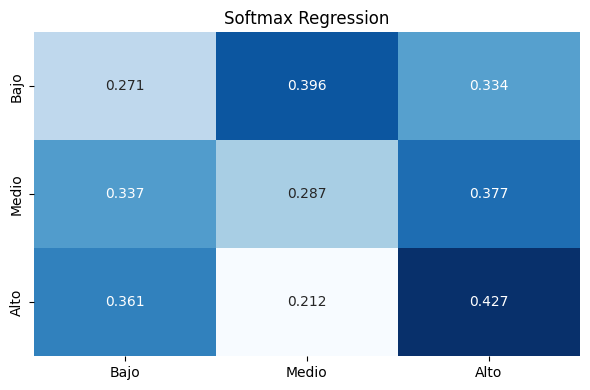

In [ ]:
# Correr el modelo sin Feature Selection o Feature Extraction

# Definir Hiperparametros
alpha = 0.000001
epochs = 500

W, LossTrain, LossTest = train(
      X_train, y_train, epochs, alpha, X_test, y_test
  )

y_pred, accuracy = test(X_test, y_test, W)

analyze_results(y_test, y_pred, "Softmax Regression")


Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.1057
Época 100: L_Train = 1.1057
Época 200: L_Train = 1.1056
Época 300: L_Train = 1.1056
Época 400: L_Train = 1.1056
Número de datos correctos: 1339
Porcentaje de aciertos: 26.78%
Porcentaje de error: 73.22%


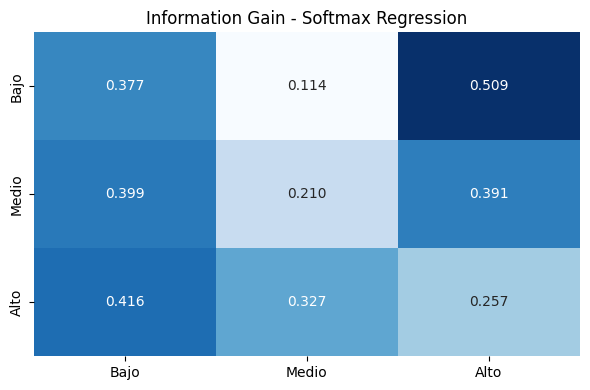

F1-Score: 0.258
Accuracy: 0.268
Recall: 0.281
Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.1009
Época 100: L_Train = 1.1009
Época 200: L_Train = 1.1008
Época 300: L_Train = 1.1008
Época 400: L_Train = 1.1008
Número de datos correctos: 1637
Porcentaje de aciertos: 32.74%
Porcentaje de error: 67.26%


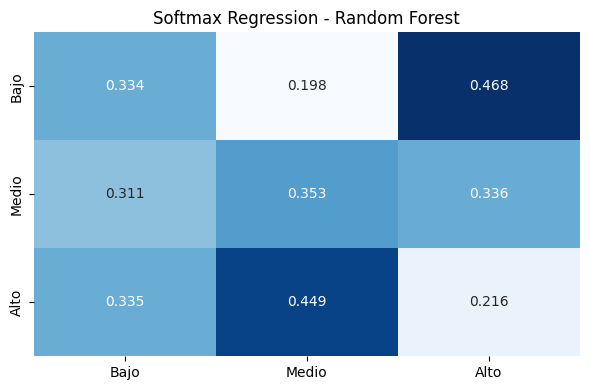

Varianza explicada acumulada con 30 componentes: 0.8894
Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.0960
Época 100: L_Train = 1.0960
Época 200: L_Train = 1.0960
Época 300: L_Train = 1.0960
Época 400: L_Train = 1.0960
Número de datos correctos: 1795
Porcentaje de aciertos: 35.90%
Porcentaje de error: 64.10%


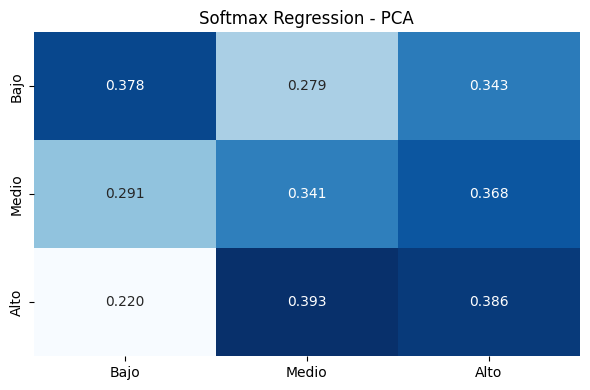

In [ ]:
# Implementar reducción de dimensionalidad

def information_gain_selection(X_train, y_train, X_test, k):
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

    top_k_indices = np.argsort(mi_scores)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

X_train_ig, X_test_ig, ig_indices = information_gain_selection(
  X_train, y_train, X_test, k=25
)

w_ig, loss_train_ig, loss_test_ig = train(
        X_train_ig,
        y_train,
        epochs,
        alpha,
        X_test_ig,
        y_test,
    )
y_pred_ig, acc_ig = test(X_test_ig, y_test, w_ig)
analyze_results(
    y_test, y_pred_ig, "Information Gain - Softmax Regression"
)

from sklearn.metrics import f1_score, accuracy_score, recall_score

f1_ig = f1_score(y_test, y_pred_ig, average='macro')
accuracy_ig = accuracy_score(y_test, y_pred_ig)
recall_ig = recall_score(y_test, y_pred_ig, average='macro')

print(f"F1-Score: {f1_ig:.3f}")
print(f"Accuracy: {accuracy_ig:.3f}")
print(f"Recall: {recall_ig:.3f}")

def random_forest_feature_importance(X_train, y_train, X_test, k):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_

    top_k_indices = np.argsort(importances)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

X_train_rf, X_test_rf, rf_indices = random_forest_feature_importance(
        X_train, y_train, X_test, k=25
    )

w_rf, loss_train_rf, loss_test_rf = train(
    X_train_rf,
    y_train,
    epochs,
    alpha,
    X_test_rf,
    y_test,
)
y_pred_rf, acc_rf = test(X_test_rf, y_test, w_rf)
analyze_results(y_test, y_pred_rf, "Softmax Regression - Random Forest")

def pca_dimensionality_reduction(X_train, X_test, n_components):

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    return X_train_pca, X_test_pca, cumulative_variance

X_train_pca, X_test_pca, variance_explained = pca_dimensionality_reduction(
        X_train, X_test, n_components=30
    )
print(
    f"Varianza explicada acumulada con 30 componentes: {variance_explained[-1]:.4f}"
)

w_pca, loss_train_pca, loss_test_pca = train(
    X_train_pca,
    y_train,
    epochs,
    alpha,
    X_test_pca,
    y_test,
)
y_pred_pca, acc_pca = test(
    X_test_pca, y_test, w_pca
)
analyze_results(y_test, y_pred_pca, "Softmax Regression - PCA")

In [ ]:
def calculate_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

f1_base = calculate_f1_score(y_test, y_pred)

f1_ig = calculate_f1_score(y_test, y_pred_ig)

f1_rf = calculate_f1_score(y_test, y_pred_rf)

f1_pca = calculate_f1_score(y_test, y_pred_pca)

models = ['Softmax\nRegression', 'Information Gain\n+ Softmax', 'Random Forest\n+ Softmax', 'PCA\n+ Softmax']
f1_scores = [f1_base, f1_ig, f1_rf, f1_pca]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)

plt.title('Comparación F1-Score entre Modelos', fontsize=16, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12)
plt.xlabel('Modelos', fontsize=12)
plt.ylim(0, 1.0)

for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() / 2,
             f'{score:.3f}', ha='center', va='center', fontweight='bold',
             color='white', fontsize=12)

plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='F1 = 0.5 (referencia)')

plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



print("F1-Scores calculados:")
print(f"Softmax Regression: {f1_base:.3f}")
print(f"Information Gain + Softmax: {f1_ig:.3f}")
print(f"Random Forest + Softmax: {f1_rf:.3f}")
print(f"PCA + Softmax: {f1_pca:.3f}")

NameError: name 'y_test' is not defined

Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.0972
Época 100: L_Train = 0.2656
Época 200: L_Train = 0.2036
Época 300: L_Train = 0.1749
Época 400: L_Train = 0.1574
Época 500: L_Train = 0.1451
Época 600: L_Train = 0.1359
Época 700: L_Train = 0.1286
Época 800: L_Train = 0.1226
Época 900: L_Train = 0.1176
Época 1000: L_Train = 0.1134
Época 1100: L_Train = 0.1096
Época 1200: L_Train = 0.1063
Época 1300: L_Train = 0.1034
Época 1400: L_Train = 0.1007
Época 1500: L_Train = 0.0984
Época 1600: L_Train = 0.0962
Época 1700: L_Train = 0.0942
Época 1800: L_Train = 0.0923
Época 1900: L_Train = 0.0906
Época 2000: L_Train = 0.0890
Época 2100: L_Train = 0.0875
Época 2200: L_Train = 0.0861
Época 2300: L_Train = 0.0848
Época 2400: L_Train = 0.0836
Época 2500: L_Train = 0.0824
Época 2600: L_Train = 0.0813
Época 2700: L_Train = 0.0802
Época 2800: L_Train = 0.0792
Época 2900: L_Train = 0.0783
Época 3000: L_Train = 0.0774
Época 3100: L_Train = 0.0765
Época 3200: L_Train = 0.0757
Época 3300: 

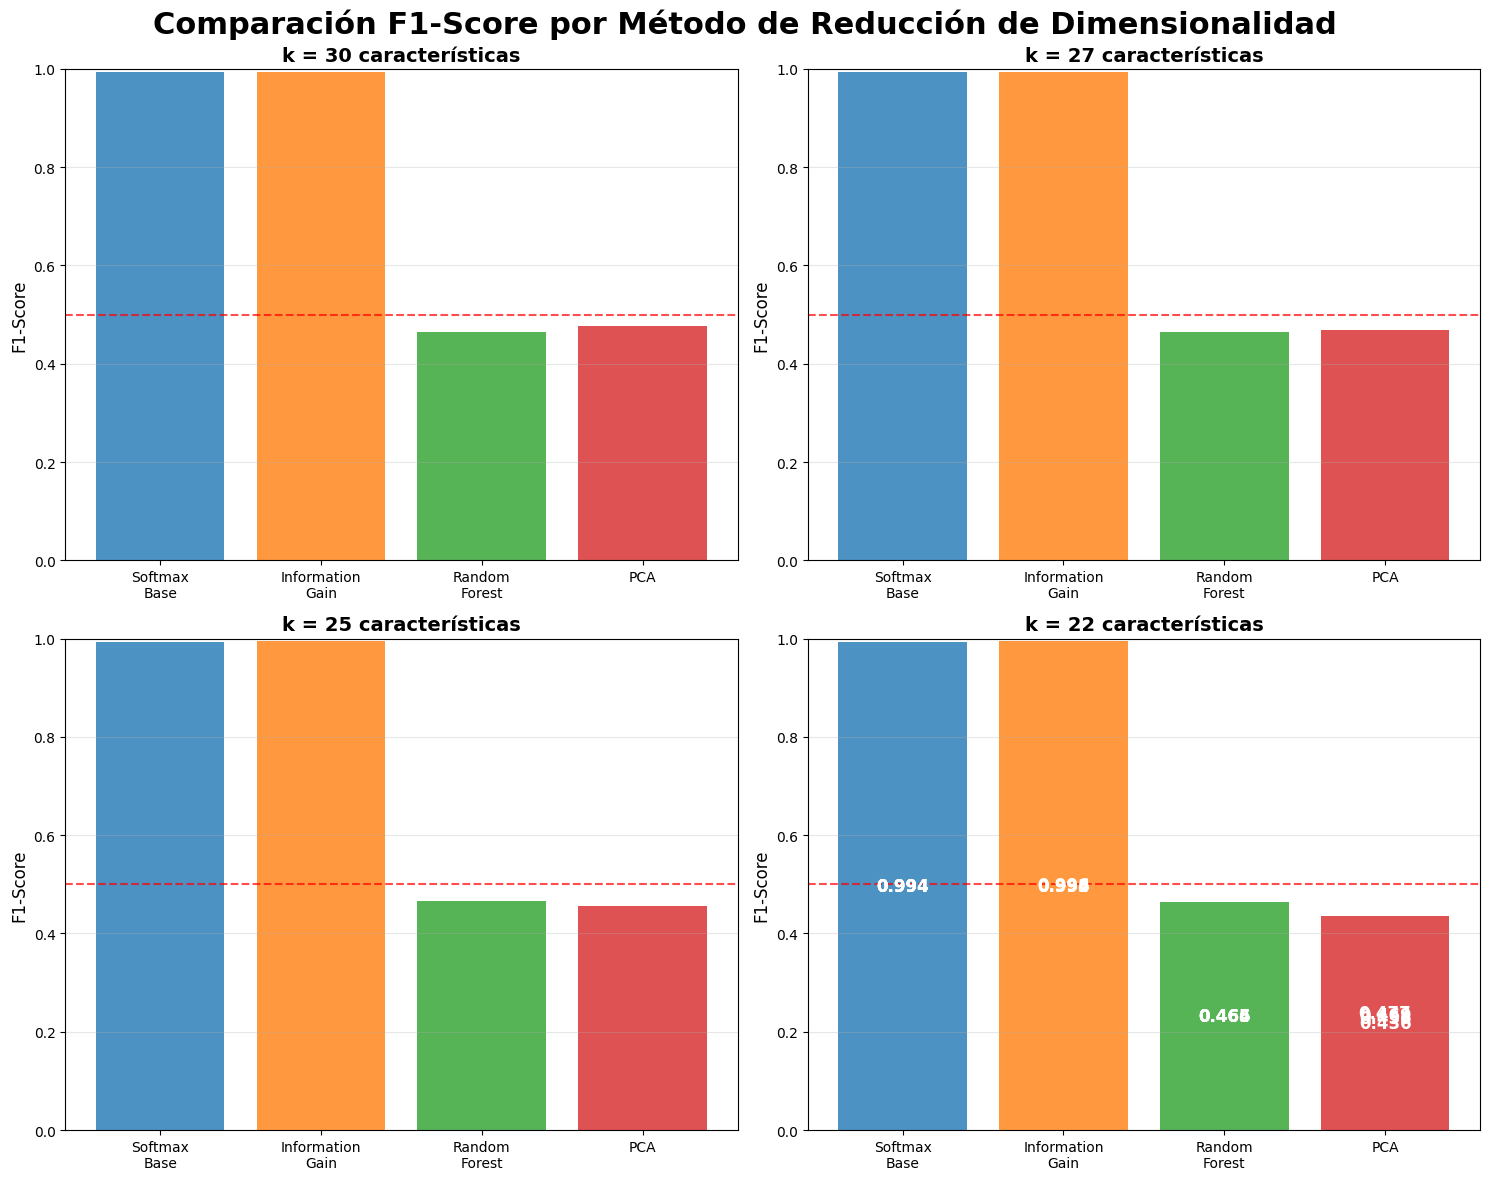

In [ ]:
# Codigo para generar un comparativo entre distintos ks
def information_gain_selection(X_train, y_train, X_test, k):
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

    top_k_indices = np.argsort(mi_scores)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

def random_forest_feature_importance(X_train, y_train, X_test, k):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_

    top_k_indices = np.argsort(importances)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

def pca_dimensionality_reduction(X_train, X_test, n_components):

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    return X_train_pca, X_test_pca, cumulative_variance


k_values = [30, 27, 25, 22]

X_train_ig_30, X_test_ig_30, ig_indices_30 = information_gain_selection(X_train, y_train, X_test, k=30)
w_ig_30, loss_train_ig_30, loss_test_ig_30 = train(X_train_ig_30, y_train, epochs, alpha, X_test_ig_30, y_test)
y_pred_ig_30, acc_ig_30 = test(X_test_ig_30, y_test, w_ig_30)

X_train_rf_30, X_test_rf_30, rf_indices_30 = random_forest_feature_importance(X_train, y_train, X_test, k=30)
w_rf_30, loss_train_rf_30, loss_test_rf_30 = train(X_train_rf_30, y_train, epochs, alpha, X_test_rf_30, y_test)
y_pred_rf_30, acc_rf_30 = test(X_test_rf_30, y_test, w_rf_30)

X_train_pca_30, X_test_pca_30, variance_explained_30 = pca_dimensionality_reduction(X_train, X_test, n_components=30)
w_pca_30, loss_train_pca_30, loss_test_pca_30 = train(X_train_pca_30, y_train, epochs, alpha, X_test_pca_30, y_test)
y_pred_pca_30, acc_pca_30 = test(X_test_pca_30, y_test, w_pca_30)

X_train_ig_27, X_test_ig_27, ig_indices_27 = information_gain_selection(X_train, y_train, X_test, k=27)
w_ig_27, loss_train_ig_27, loss_test_ig_27 = train(X_train_ig_27, y_train, epochs, alpha, X_test_ig_27, y_test)
y_pred_ig_27, acc_ig_27 = test(X_test_ig_27, y_test, w_ig_27)

X_train_rf_27, X_test_rf_27, rf_indices_27 = random_forest_feature_importance(X_train, y_train, X_test, k=27)
w_rf_27, loss_train_rf_27, loss_test_rf_27 = train(X_train_rf_27, y_train, epochs, alpha, X_test_rf_27, y_test)
y_pred_rf_27, acc_rf_27 = test(X_test_rf_27, y_test, w_rf_27)

X_train_pca_27, X_test_pca_27, variance_explained_27 = pca_dimensionality_reduction(X_train, X_test, n_components=27)
w_pca_27, loss_train_pca_27, loss_test_pca_27 = train(X_train_pca_27, y_train, epochs, alpha, X_test_pca_27, y_test)
y_pred_pca_27, acc_pca_27 = test(X_test_pca_27, y_test, w_pca_27)

X_train_ig_25, X_test_ig_25, ig_indices_25 = information_gain_selection(X_train, y_train, X_test, k=25)
w_ig_25, loss_train_ig_25, loss_test_ig_25 = train(X_train_ig_25, y_train, epochs, alpha, X_test_ig_25, y_test)
y_pred_ig_25, acc_ig_25 = test(X_test_ig_25, y_test, w_ig_25)

X_train_rf_25, X_test_rf_25, rf_indices_25 = random_forest_feature_importance(X_train, y_train, X_test, k=25)
w_rf_25, loss_train_rf_25, loss_test_rf_25 = train(X_train_rf_25, y_train, epochs, alpha, X_test_rf_25, y_test)
y_pred_rf_25, acc_rf_25 = test(X_test_rf_25, y_test, w_rf_25)

X_train_pca_25, X_test_pca_25, variance_explained_25 = pca_dimensionality_reduction(X_train, X_test, n_components=25)
w_pca_25, loss_train_pca_25, loss_test_pca_25 = train(X_train_pca_25, y_train, epochs, alpha, X_test_pca_25, y_test)
y_pred_pca_25, acc_pca_25 = test(X_test_pca_25, y_test, w_pca_25)

X_train_ig_22, X_test_ig_22, ig_indices_22 = information_gain_selection(X_train, y_train, X_test, k=22)
w_ig_22, loss_train_ig_22, loss_test_ig_22 = train(X_train_ig_22, y_train, epochs, alpha, X_test_ig_22, y_test)
y_pred_ig_22, acc_ig_22 = test(X_test_ig_22, y_test, w_ig_22)

X_train_rf_22, X_test_rf_22, rf_indices_22 = random_forest_feature_importance(X_train, y_train, X_test, k=22)
w_rf_22, loss_train_rf_22, loss_test_rf_22 = train(X_train_rf_22, y_train, epochs, alpha, X_test_rf_22, y_test)
y_pred_rf_22, acc_rf_22 = test(X_test_rf_22, y_test, w_rf_22)

X_train_pca_22, X_test_pca_22, variance_explained_22 = pca_dimensionality_reduction(X_train, X_test, n_components=22)
w_pca_22, loss_train_pca_22, loss_test_pca_22 = train(X_train_pca_22, y_train, epochs, alpha, X_test_pca_22, y_test)
y_pred_pca_22, acc_pca_22 = test(X_test_pca_22, y_test, w_pca_22)

def calculate_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

f1_base = calculate_f1_score(y_test, y_pred)

f1_ig_30 = calculate_f1_score(y_test, y_pred_ig_30)
f1_rf_30 = calculate_f1_score(y_test, y_pred_rf_30)
f1_pca_30 = calculate_f1_score(y_test, y_pred_pca_30)

f1_ig_27 = calculate_f1_score(y_test, y_pred_ig_27)
f1_rf_27 = calculate_f1_score(y_test, y_pred_rf_27)
f1_pca_27 = calculate_f1_score(y_test, y_pred_pca_27)

f1_ig_25 = calculate_f1_score(y_test, y_pred_ig_25)
f1_rf_25 = calculate_f1_score(y_test, y_pred_rf_25)
f1_pca_25 = calculate_f1_score(y_test, y_pred_pca_25)

f1_ig_22 = calculate_f1_score(y_test, y_pred_ig_22)
f1_rf_22 = calculate_f1_score(y_test, y_pred_rf_22)
f1_pca_22 = calculate_f1_score(y_test, y_pred_pca_22)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación F1-Score por Método de Reducción de Dimensionalidad', fontsize=22, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, k in enumerate(k_values):
    ax = axes[i//2, i%2]

    if k == 30:
        models = ['Softmax\nBase', 'Information\nGain', 'Random\nForest', 'PCA']
        f1_scores = [f1_base, f1_ig_30, f1_rf_30, f1_pca_30]
    elif k == 27:
        models = ['Softmax\nBase', 'Information\nGain', 'Random\nForest', 'PCA']
        f1_scores = [f1_base, f1_ig_27, f1_rf_27, f1_pca_27]
    elif k == 25:
        models = ['Softmax\nBase', 'Information\nGain', 'Random\nForest', 'PCA']
        f1_scores = [f1_base, f1_ig_25, f1_rf_25, f1_pca_25]
    elif k == 22:
        models = ['Softmax\nBase', 'Information\nGain', 'Random\nForest', 'PCA']
        f1_scores = [f1_base, f1_ig_22, f1_rf_22, f1_pca_22]

    bars = ax.bar(models, f1_scores, color=colors, alpha=0.8)
    ax.set_title(f'k = {k} características', fontsize=14, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_ylim(0, 1.0)

    for i, (bar, score) in enumerate(zip(bars, f1_scores)):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() / 2,
          f'{score:.3f}', ha='center', va='center', fontweight='bold',
             color='white', fontsize=12)

    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()